# Análises Macroeconômicas #

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
dataInicial = "01/01/2000"
dataFinal = "01/01/2010"

## Consultas às APIS do BACEN ##

### Histórico do PTAX Dólar/Real ###

In [3]:
def consulta_bc(dataInicial, dataFinal):
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    print(f"Buscando: {dataInicial} até {dataFinal}")
    
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

# Lista para armazenar os DataFrames de cada década
frames = []

for i in range(2000, 2026, 10):
    # Define o fim do intervalo: ou i+10 ou o limite 2025
    f = i + 10 if (i + 10) <= 2026 else 2026
    
    data_ini = f"01/01/{i}"
    data_fim = f"01/01/{f}" # Ajustado para 31/12 para pegar o ano cheio
    
    # Chama a função e guarda o resultado na lista
    df_intervalo = consulta_bc(data_ini, data_fim)
    frames.append(df_intervalo)

# Concatena todos os intervalos em um único DataFrame final
historico_dolar = pd.concat(frames)
historico_dolar.columns = ['dolar_ptax']

print("\nResultados finais (últimas linhas):")
historico_dolar.head(5)

Buscando: 01/01/2000 até 01/01/2010
Buscando: 01/01/2010 até 01/01/2020
Buscando: 01/01/2020 até 01/01/2026

Resultados finais (últimas linhas):


,dolar_ptax
data,
2000-01-03,1.8003
2000-01-04,1.8329
2000-01-05,1.8536
2000-01-06,1.8453
2000-01-07,1.8273


### Histórico da taxa básica de juros (SELIC) ###

In [4]:
def consulta_selic(dataInicial, dataFinal):
    # Código 11 é a Selic acumulada no mês / Código 432 é a Selic Meta (anualizada)
    # Usaremos o 11 para seguir o padrão de série histórica
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    print(f"Buscando Selic: {dataInicial} até {dataFinal}")
    
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

frames_selic = []

for i in range(2000, 2026, 10):
    f = i + 10 if (i + 10) <= 2026 else 2026
    
    # Definindo os períodos de análise
    inicio = f"01/01/{i}"
    fim = f"01/01/{f}"
    
    df_intervalo = consulta_selic(inicio, fim)
    frames_selic.append(df_intervalo)

# Consolida os dados
historico_selic = pd.concat(frames_selic)
historico_selic.columns = ['Selic_Diaria']

print("\nÚltimos registros da Selic:")
historico_selic.head(5)

Buscando Selic: 01/01/2000 até 01/01/2010
Buscando Selic: 01/01/2010 até 01/01/2020
Buscando Selic: 01/01/2020 até 01/01/2026

Últimos registros da Selic:


,Selic_Diaria
data,
2000-01-03,0.069186
2000-01-04,0.069186
2000-01-05,0.069220
2000-01-06,0.069286
2000-01-07,0.069286


In [5]:
# Convertendo SELIC diária para anual
historico_selic['Selic_Anual'] = (1 + historico_selic['Selic_Diaria']/100) ** 252 - 1

historico_selic.head(3)

,Selic_Diaria,Selic_Anual
data,,
2000-01-03,0.069186,0.190399
2000-01-04,0.069186,0.190399
2000-01-05,0.069220,0.190501


### Histórico da taxa básica de juros (SELIC) ###

In [6]:
def consulta_inflacao(dataInicial, dataFinal):
    # Série 433: IPCA - Variação mensal (%)
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.13522/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    print(f"Buscando IPCA: {dataInicial} até {dataFinal}")
    
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

frames_ipca = []

for i in range(2000, 2026, 10):
    f = i + 10 if (i + 10) <= 2026 else 2026
    inicio = f"01/01/{i}"
    fim = f"01/01/{f}"
    
    df_intervalo = consulta_inflacao(inicio, fim)
    frames_ipca.append(df_intervalo)

historico_ipca = pd.concat(frames_ipca)
historico_ipca.columns = ['ipca_anual']

print("\nÚltimos registros do IPCA:")
print(historico_ipca.tail())

Buscando IPCA: 01/01/2000 até 01/01/2010
Buscando IPCA: 01/01/2010 até 01/01/2020
Buscando IPCA: 01/01/2020 até 01/01/2026

Últimos registros do IPCA:
            ipca_anual
data                  
2025-09-01        5.17
2025-10-01        4.68
2025-11-01        4.46
2025-12-01        4.26
2026-01-01        4.44


### Mesclando os dados históricos do preço do dólar e da taxa SELIC ###

In [7]:
df = pd.merge(historico_dolar, historico_selic, how='left', left_index=True, right_index=True)
df.columns = ['Dolar', 'Selic_Diaria', 'Selic_Anual']

In [8]:
df = pd.merge(df, historico_ipca, how='outer', left_index=True, right_index=True)

In [9]:
df.rename(columns={'Dolar': 'Dólar (PTAX)', 'Selic_Diaria': 'Selic Diária (%)', 'Selic_Anual': 'Selic Anual (%)', 'ipca_anual': 'IPCA Anual (%)'}, inplace=True)

In [10]:
df.head(45)

,Dólar (PTAX),Selic Diária (%),Selic Anual (%),IPCA Anual (%)
data,,,,
2000-01-01,NaN,NaN,NaN,8.85
2000-01-03,1.8003,0.069186,0.190399,NaN
2000-01-04,1.8329,0.069186,0.190399,NaN
2000-01-05,1.8536,0.069220,0.190501,NaN
2000-01-06,1.8453,0.069286,0.190699,NaN
2000-01-07,1.8273,0.069286,0.190699,NaN
2000-01-10,1.8153,0.069120,0.190201,NaN
2000-01-11,1.8211,0.068986,0.189799,NaN
2000-01-12,1.8306,0.068819,0.189299,NaN


In [11]:
df['IPCA Anual (%)'] = (df['IPCA Anual (%)'] / 100)

In [12]:
# 1. Remover duplicatas de índice (causadas pela sobreposição do loop)
# Isso remove as datas repetidas mantendo a primeira entrada
df = df[~df.index.duplicated(keep='first')]

# 2. Garantir que o índice esteja em ordem cronológica
df = df.sort_index()

# 3. Criar o novo intervalo diário
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# 4. Reindexar e preencher os buracos (ffill)
# Agora o erro de 'duplicate labels' não acontecerá mais
df = df.reindex(idx).ffill()

# 5. (Opcional) bfill para garantir que o início da tabela não tenha NaNs
df = df.bfill()

print("Duplicatas removidas e dados preenchidos com sucesso!")
print(df.head(10))

Duplicatas removidas e dados preenchidos com sucesso!
            Dólar (PTAX)  Selic Diária (%)  Selic Anual (%)  IPCA Anual (%)
2000-01-01        1.8003          0.069186         0.190399          0.0885
2000-01-02        1.8003          0.069186         0.190399          0.0885
2000-01-03        1.8003          0.069186         0.190399          0.0885
2000-01-04        1.8329          0.069186         0.190399          0.0885
2000-01-05        1.8536          0.069220         0.190501          0.0885
2000-01-06        1.8453          0.069286         0.190699          0.0885
2000-01-07        1.8273          0.069286         0.190699          0.0885
2000-01-08        1.8273          0.069286         0.190699          0.0885
2000-01-09        1.8273          0.069286         0.190699          0.0885
2000-01-10        1.8153          0.069120         0.190201          0.0885


Plotar os dados de câmbio e SELIC em um gráfico

No gráfico acima, é possível observar que, em 2022, o aumento na taxa básica de juros provocou uma queda imediata no preço do dólar

Importando a taxa básica de juros americana (FED RATE)

In [13]:
from fredapi import Fred
import pandas as pd

# Substitua pela sua chave real
fred = Fred(api_key='740ee3f0157b9dbd3fe23ce1c4927102')

# FEDFUNDS é a taxa mensal; para a diária use 'DFF'
fed_rate = fred.get_series('FEDFUNDS', observation_start='2000-01-01')

# Transformando em DataFrame para analisar com ML
df_fed = pd.DataFrame(fed_rate, columns=['Fed_Rate'])

In [14]:
df_fed

,Fed_Rate
2000-01-01,5.45
2000-02-01,5.73
2000-03-01,5.85
2000-04-01,6.02
2000-05-01,6.27
...,...
2025-09-01,4.22
2025-10-01,4.09
2025-11-01,3.88
2025-12-01,3.72


In [15]:
df_juros = pd.merge(df, df_fed, how='left', left_index=True, right_index=True)

In [16]:
df_juros.rename(columns={'Fed_Rate': 'Fed Rate (%)'}, inplace=True)

In [17]:
idx = pd.date_range(start=df_juros.index.min(), end=df_juros.index.max(), freq='D')
df_juros = df_juros.reindex(idx)

# 2. A Mágica: Preencher os dados em branco com o último valor disponível
df_juros = df_juros.ffill()

# Se você quiser preencher apenas colunas específicas:
# df[['Dolar', 'Selic']] = df[['Dolar', 'Selic']].ffill()

print(df_juros.head(10))

            Dólar (PTAX)  Selic Diária (%)  Selic Anual (%)  IPCA Anual (%)  \
2000-01-01        1.8003          0.069186         0.190399          0.0885   
2000-01-02        1.8003          0.069186         0.190399          0.0885   
2000-01-03        1.8003          0.069186         0.190399          0.0885   
2000-01-04        1.8329          0.069186         0.190399          0.0885   
2000-01-05        1.8536          0.069220         0.190501          0.0885   
2000-01-06        1.8453          0.069286         0.190699          0.0885   
2000-01-07        1.8273          0.069286         0.190699          0.0885   
2000-01-08        1.8273          0.069286         0.190699          0.0885   
2000-01-09        1.8273          0.069286         0.190699          0.0885   
2000-01-10        1.8153          0.069120         0.190201          0.0885   

            Fed Rate (%)  
2000-01-01          5.45  
2000-01-02          5.45  
2000-01-03          5.45  
2000-01-04          5.

In [18]:
df_juros['Fed Rate (%)'] = (df_juros['Fed Rate (%)']/100)

In [19]:
df_juros.head(5)

,Dólar (PTAX),Selic Diária (%),Selic Anual (%),IPCA Anual (%),Fed Rate (%)
2000-01-01,1.8003,0.069186,0.190399,0.0885,0.0545
2000-01-02,1.8003,0.069186,0.190399,0.0885,0.0545
2000-01-03,1.8003,0.069186,0.190399,0.0885,0.0545
2000-01-04,1.8329,0.069186,0.190399,0.0885,0.0545
2000-01-05,1.8536,0.069220,0.190501,0.0885,0.0545


In [41]:
import yfinance as yf

# 1. Download garantindo que pegamos apenas o que precisamos
# Se 'Adj Close' não existir, usamos 'Close' (para o Ibov são quase idênticos)
ibov = yf.download('^BVSP', start='2000-01-01', end='2025-12-31')

[*********************100%***********************]  1 of 1 completed


In [42]:
ibov['Close']

Ticker,^BVSP
Date,
2000-01-03,16930.0
2000-01-04,15851.0
2000-01-05,16245.0
2000-01-06,16107.0
2000-01-07,16309.0
...,...
2025-12-22,158142.0
2025-12-23,160456.0
2025-12-26,160897.0


In [43]:
df = pd.merge(df, ibov['Close'], how='left', left_index=True, right_index=True)

In [44]:
df

,Dólar (PTAX),Selic Diária (%),Selic Anual (%),IPCA Anual (%),^BVSP
2000-01-01,1.8003,0.069186,0.190399,0.0885,NaN
2000-01-02,1.8003,0.069186,0.190399,0.0885,NaN
2000-01-03,1.8003,0.069186,0.190399,0.0885,16930.0
2000-01-04,1.8329,0.069186,0.190399,0.0885,15851.0
2000-01-05,1.8536,0.069220,0.190501,0.0885,16245.0
...,...,...,...,...,...
2025-12-28,5.5407,0.055131,0.149000,0.0426,NaN
2025-12-29,5.5733,0.055131,0.149000,0.0426,160490.0
2025-12-30,5.5018,0.055131,0.149000,0.0426,161125.0
2025-12-31,5.5018,0.055131,0.149000,0.0426,NaN


In [50]:

# 3. Criar o novo intervalo diário
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

In [51]:

df_teste = df.reindex(idx).ffill()

# 5. (Opcional) bfill para garantir que o início da tabela não tenha NaNs
df = df.bfill()

df.rename(columns={'^BVSP': 'BVSP'}, inplace=True)

In [52]:
df

,Dólar (PTAX),Selic Diária (%),Selic Anual (%),IPCA Anual (%),BVSP
2000-01-01,1.8003,0.069186,0.190399,0.0885,16930.0
2000-01-02,1.8003,0.069186,0.190399,0.0885,16930.0
2000-01-03,1.8003,0.069186,0.190399,0.0885,16930.0
2000-01-04,1.8329,0.069186,0.190399,0.0885,15851.0
2000-01-05,1.8536,0.069220,0.190501,0.0885,16245.0
...,...,...,...,...,...
2025-12-28,5.5407,0.055131,0.149000,0.0426,160490.0
2025-12-29,5.5733,0.055131,0.149000,0.0426,160490.0
2025-12-30,5.5018,0.055131,0.149000,0.0426,161125.0
2025-12-31,5.5018,0.055131,0.149000,0.0426,NaN


Salvar o df 

In [53]:
df.to_csv('archives/dados_bacen.csv')

In [1]:
import pandas as pd

def consulta_bc(codigo_serie, dataInicial, dataFinal):
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    try:
        df = pd.read_json(url)
        df['data'] = pd.to_datetime(df['data'], dayfirst=True)
        df.set_index('data', inplace=True)
        return df
    except Exception as e:
        print(f"Erro na série {codigo_serie}: {e}")
        return pd.DataFrame()

# Definição do período (Lembrando que o IC-Br começa em 2005)
data_ini = "01/01/2000"
data_fim = "01/01/2026"

# Buscando o IC-Br Total (27574) e Agro (27575)
icbr_total = consulta_bc(27574, data_ini, data_fim)
icbr_agro = consulta_bc(27575, data_ini, data_fim)

# Organizando o DataFrame final
df_icbr = pd.concat([icbr_total, icbr_agro], axis=1)
df_icbr.columns = ['icbr_total', 'icbr_agro']

print(f"Dados coletados: {len(df_icbr)} meses.")
df_icbr.tail()

Dados coletados: 313 meses.


,icbr_total,icbr_agro
data,,
2025-09-01,428.13,470.65
2025-10-01,427.03,460.31
2025-11-01,414.05,435.32
2025-12-01,431.84,450.68
2026-01-01,440.25,447.12


In [2]:
# Código SGS 1635: IPCA - Alimentação e bebidas - Variação mensal (%)
def consulta_bc_alimentacao(dataInicial, dataFinal):
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.1635/dados?formato=json&dataInicial={dataInicial}&dataFinal={dataFinal}"
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

# Seguindo a sua lógica de décadas
frames_ipca = []
for i in range(2000, 2026, 10):
    f = i + 10 if (i + 10) <= 2026 else 2026
    df_int = consulta_bc_alimentacao(f"01/01/{i}", f"01/01/{f}")
    frames_ipca.append(df_int)

historico_ipca_ali = pd.concat(frames_ipca)
historico_ipca_ali.columns = ['ipca_alimentacao']

In [3]:
historico_ipca_ali

,ipca_alimentacao
data,
2000-01-01,0.84
2000-02-01,-0.25
2000-03-01,-0.46
2000-04-01,-0.36
2000-05-01,-0.67
...,...
2025-09-01,-0.26
2025-10-01,0.01
2025-11-01,-0.01


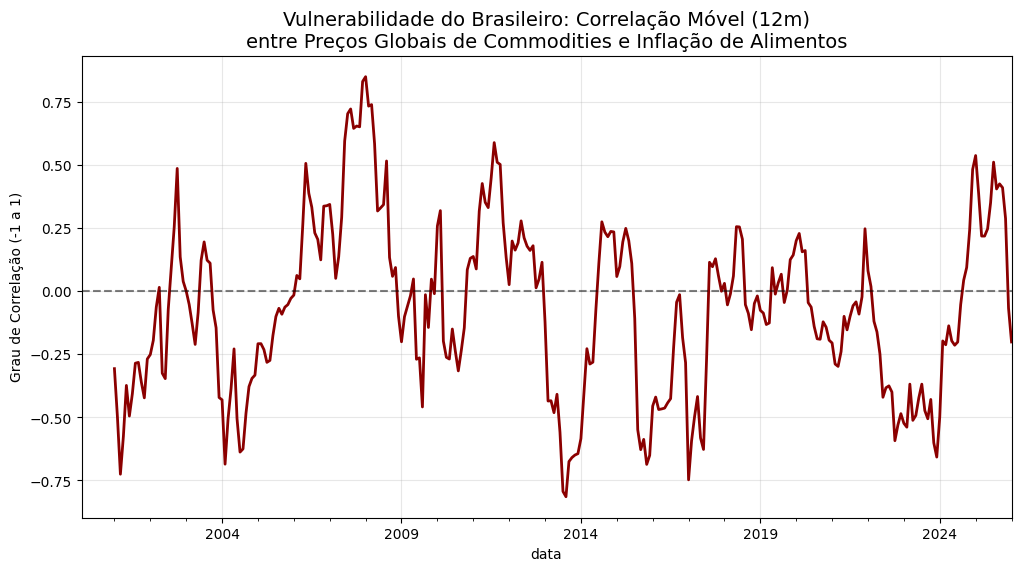

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def consulta_bc(codigo, data_ini, data_fim):
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo}/dados?formato=json&dataInicial={data_ini}&dataFinal={data_fim}"
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

# Período de análise (IC-Br disponível a partir de 2005)
ini, fim = "01/01/2000", "01/01/2026"

# 1635 = IPCA Alimentos | 27575 = IC-Br Agro
ipca_ali = consulta_bc(1635, ini, fim)
icbr_agro = consulta_bc(27575, ini, fim)

# Unificando e calculando a variação mensal do IC-Br (para comparar % com %)
df_estudo = pd.concat([ipca_ali, icbr_agro.pct_change() * 100], axis=1).dropna()
df_estudo.columns = ['IPCA_Alimentos', 'ICBR_Agro_Var']

# Calculando a Correlação Móvel (Janela de 12 meses)
correlacao = df_estudo['IPCA_Alimentos'].rolling(12).corr(df_estudo['ICBR_Agro_Var'])

# Plotando o Gráfico de Vulnerabilidade
plt.figure(figsize=(12, 6))
correlacao.plot(color='darkred', lw=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Vulnerabilidade do Brasileiro: Correlação Móvel (12m)\nentre Preços Globais de Commodities e Inflação de Alimentos', fontsize=14)
plt.ylabel('Grau de Correlação (-1 a 1)')
plt.grid(alpha=0.3)
plt.savefig('vulnerabilidade_alimentos.png')